In [2]:
# Tianyu Lu
# HW2_question2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
import random

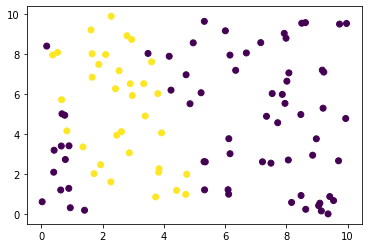

In [3]:
df = pd.read_csv('classification.csv')
x=df.values[:, 0:2]
y=df.values[:,2]
# visualize data
plt.scatter(x[:, 0], x[:, 1],c=y)
plt.show() 

In [4]:
# divide x, y into k list of same size
def getSplitData(x, y, k):
    arr = [i for i in range(len(x))]
    random.shuffle(arr)
    pList = np.array_split(np.array(arr), k)
    xlist, ylist = [], []
    for fold in pList:
        xlist.append(x[fold])
        ylist.append(y[fold])
    return xlist, ylist

In [5]:
# randomly draw n samples from x, y
def drawSample(x, y, n):
    arr = [i for i in range(len(x))]
    random.shuffle(arr)
    p1, p2 = arr[:n], arr[n:]
    return x[p1], x[p2], y[p1], y[p2]

In [6]:
# return 5-fold CV train accuracy
def crossValidation(x, y):
    #split data for cross-validation
    xlist, ylist = getSplitData(x, y, 5)
    trainAcc = []
    for i in range(5):
        model = LogisticRegression()
        xtest, ytest = xlist[i], ylist[i]
        xtrain = np.concatenate((xlist[:i] + xlist[i+1:]))
        ytrain = np.concatenate((ylist[:i] + ylist[i+1:]))
        model.fit(xtrain, ytrain)
        trainAcc.append(metrics.accuracy_score(ytest, model.predict(xtest)))
    model = LogisticRegression()
    model.fit(x, y)
    return model, np.mean(trainAcc)

In [7]:
# draw samples uniformly with replacement from training 
# return trained committee of models 
def bagging(xtrain, ytrain, n):
    l = [i for i in range(len(xtrain))]
    committee=[]
    for i in range(n):
        pos = np.random.choice(l, size=len(xtrain), replace=True)
        bagX, bagY = xtrain[pos], ytrain[pos]
        model = LogisticRegression()
        model.fit(bagX, bagY)
        committee.append(model)
    return committee

In [8]:
# find the data that has highest disagreement in the committee
def queryCommittee(models, xtest, ytest):
    adj = 1.0e-20 # handle log(0)
    entropy=[]
    for x in xtest:
        # get prediction from all models
        pred =[models[i].predict_proba(x.reshape(1,-1))[:,0] for i in range(10)]
        e = np.mean(pred)
        #calculate soft vote entropy
        entropy.append(-e*np.log2(e+adj)-(1-e)*np.log2(1-e+adj))
    p = np.argmax(entropy) 
    return xtest[p], ytest[p], np.delete(xtest, p, 0), np.delete(ytest, p)

In [9]:
# q1: query by committee
# using a random forest with 10 trees
def trainQueryCommittee(x, y):
    xObs, xUnob, yObs, yUnob = drawSample(x, y, 20) 
    trainAcc, testAcc = [], []
    while len(xUnob) > 0:
        model, train = crossValidation(xObs, yObs) 
        trainAcc.append(train)
        testAcc.append(metrics.accuracy_score(yUnob, model.predict(xUnob)))
        # update sample
        committee = bagging(xObs, yObs, 10)
        xNew, yNew, xUnob, yUnob = queryCommittee(committee, xUnob, yUnob)
        xObs = np.concatenate((xObs, [xNew]))
        yObs = np.concatenate((yObs, [yNew]))
    return trainAcc, testAcc

In [10]:
# run queryByCommittee
obs, unobs = [], []
for i in range(10):
    random.seed(i)
    print(i)
    train, test = trainQueryCommittee(x, y)
    obs.append(train)
    unobs.append(test)
    
# calculate mean and std for 10 simulation
obsMean = [np.mean(i) for i in np.transpose(np.array(obs))]
obsStd = [np.std(i) for i in np.transpose(np.array(obs))]
unobsMean = [np.mean(i) for i in np.transpose(np.array(unobs))]
unobsStd = [np.std(i) for i in np.transpose(np.array(unobs))]
print("first round", obsMean[0], obsStd[0])

0
1
2
3
4
5
6
7
8
9
first round 0.7300000000000001 0.10535653752852739


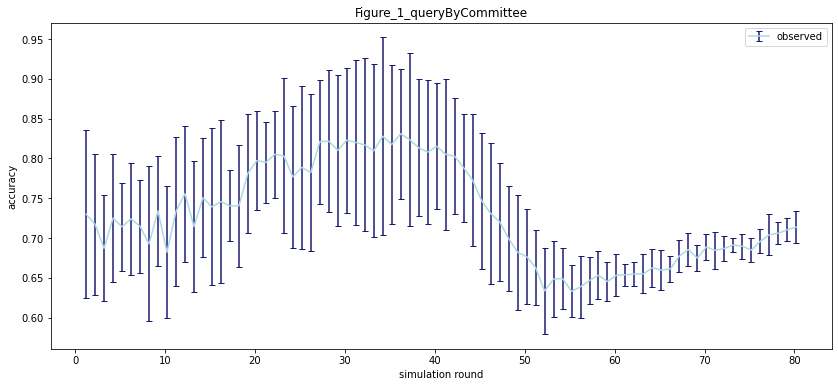

In [12]:
# plot q1 figure
xaxis = np.arange(len(obsMean))
plt.rcParams["figure.figsize"] = (14,6)
plt.errorbar(xaxis, obsMean, yerr = obsStd,  label = 'observed', color = 'lightblue', ecolor='midnightblue',capsize=3)
# plt.errorbar(xaxis+0.8, unobsMean, yerr = unobsStd, label = 'unobserved', color = 'darkgrey', ecolor='slategrey',capsize=3)

plt.xlabel("simulation round")
plt.ylabel("accuracy")
plt.title("Figure_1_queryByCommittee")
plt.legend()
plt.show()

In [13]:
# query selection with minimizing expected risk
def minRisk(model, xtrain, ytrain, xtest, ytest):
    expectedRisk = []
    for i, x in enumerate(xtest):
        risk = 0
        # create new dataset
        xtr2=np.concatenate((xtrain,[x]))
        xte2=np.delete(xtest, i, 0)
        for il, l in enumerate(model.classes_):
            ytr2=np.concatenate((ytrain,[l])) # predicted y label
            p1 = model.predict_proba(x.reshape(1,-1))[:,il] # current model probability
            newModel=LogisticRegression() # train new model with new data|
            newModel.fit(xtr2, ytr2) 
            p2 = sum([1-np.max((newModel.predict_proba(x2.reshape(1, -1)))) for x2 in xte2])
            risk += p1*p2
        expectedRisk.append(risk)
    p = np.argmin(expectedRisk) # select data with min expected risk
    return xtest[p], ytest[p], np.delete(xtest, p, 0), np.delete(ytest, p)           

In [14]:
# train model with min risk sampling 
def trainMinRisk(x, y):
    xObs, xUnob, yObs, yUnob = drawSample(x, y, 20) 
    trainAcc, testAcc = [], []
    while len(xUnob) > 0:
        model, train = crossValidation(xObs, yObs) 
        trainAcc.append(train)
        testAcc.append(metrics.accuracy_score(yUnob, model.predict(xUnob)))
        # update sample
        xNew, yNew, xUnob, yUnob = minRisk(model, xObs, yObs, xUnob, yUnob)
        xObs = np.concatenate((xObs, [xNew]))
        yObs = np.concatenate((yObs, [yNew]))
    return trainAcc, testAcc

In [15]:
# train with min expected risk
obs, unobs = [], []
for i in range(10):
    random.seed(i)
    print(i)
    train, test = trainMinRisk(x, y)
    obs.append(train)
    unobs.append(test)
    
# calculate mean and std for 10 simulation
obsMean = [np.mean(i) for i in np.transpose(np.array(obs))]
obsStd = [np.std(i) for i in np.transpose(np.array(obs))]
unobsMean = [np.mean(i) for i in np.transpose(np.array(unobs))]
unobsStd = [np.std(i) for i in np.transpose(np.array(unobs))]
print("first round", obsMean[0], obsStd[0])

0
1
2
3
4
5
6
7
8
9
first round 0.7300000000000001 0.10535653752852739


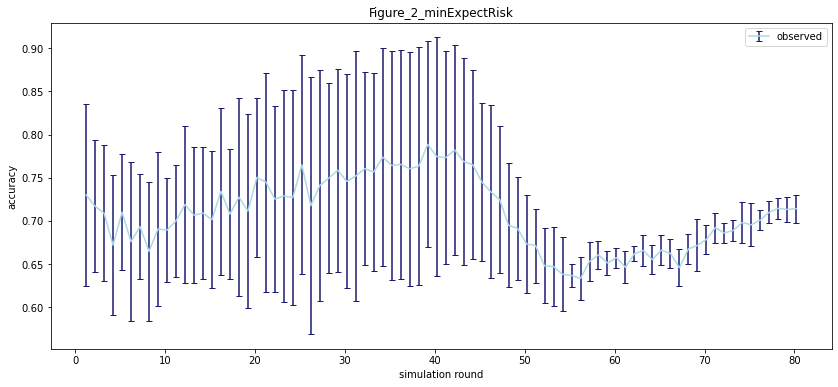

In [18]:
# plot q2 figure
xaxis = np.arange(len(obsMean))
plt.rcParams["figure.figsize"] = (14,6)
plt.errorbar(xaxis, obsMean, yerr = obsStd,  label = 'observed', color = 'lightblue', ecolor='midnightblue',capsize=3)
# plt.errorbar(xaxis+0.8, unobsMean, yerr = unobsStd, label = 'unobserved', color = 'darkgrey', ecolor='slategrey',capsize=3)

plt.xlabel("simulation round")
plt.ylabel("accuracy")
plt.title("Figure_2_minExpectRisk")
plt.legend()
plt.show()

In [32]:
def densitySample(model, xtrain, ytrain, xtest, ytest):
    density = []
    # calculate uncertainty for xtest
    sxx = sum(xtrain)**2-sum(xtrain)**2/len(xtrain)
    s = metrics.mean_squared_error(ytrain, model.predict(xtrain))
    var = [np.linalg.norm(np.array(s**2*(1/len(xtrain)+(i-np.mean(xtrain))**2/sxx))) for i in xtest]
    # calculate averaged similarity
    for i, x1 in enumerate(xtest):
        sim = [np.linalg.norm(x1-x2) for x2 in xtest]
        density.append(var[i] * np.mean(sim))
    p = np.argmax(var) # selects the greatest information density
    return xtest[p], ytest[p], np.delete(xtest, p, 0), np.delete(ytest, p)

In [20]:
# train model with density sampling
def trainDensity(x, y):
    xObs, xUnob, yObs, yUnob = drawSample(x, y, 20) 
    trainAcc, testAcc = [], []
    while len(xUnob) > 0:
        model, train = crossValidation(xObs, yObs) 
        trainAcc.append(train)
        testAcc.append(metrics.accuracy_score(yUnob, model.predict(xUnob)))
        # update sample
        xNew, yNew, xUnob, yUnob = densitySample(model, xObs, yObs, xUnob, yUnob)
        xObs = np.concatenate((xObs, [xNew]))
        yObs = np.concatenate((yObs, [yNew]))
    return trainAcc, testAcc

In [34]:
# train with density sampling
obs, unobs = [], []
for i in range(10):
    random.seed(i)
    print(i)
    train, test = trainDensity(x, y)
    obs.append(train)
    unobs.append(test)
    
# calculate mean and std for 10 simulation
obsMean = [np.mean(i) for i in np.transpose(np.array(obs))]
obsStd = [np.std(i) for i in np.transpose(np.array(obs))]
unobsMean = [np.mean(i) for i in np.transpose(np.array(unobs))]
unobsStd = [np.std(i) for i in np.transpose(np.array(unobs))]
print("first round", obsMean[0], obsStd[0])

0
1
2
3
4
5
6
7
8
9
first round 0.7300000000000001 0.10535653752852739


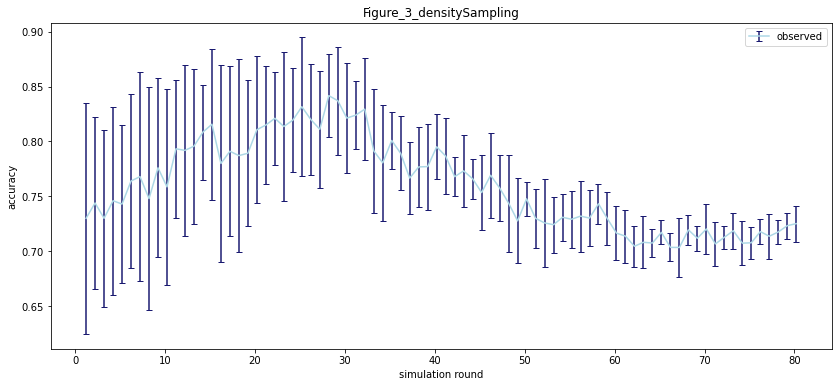

In [35]:
# plot q2 figure
xaxis = np.arange(len(obsMean))
plt.rcParams["figure.figsize"] = (14,6)
plt.errorbar(xaxis, obsMean, yerr = obsStd,  label = 'observed', color = 'lightblue', ecolor='midnightblue',capsize=3)
# plt.errorbar(xaxis+0.8, unobsMean, yerr = unobsStd, label = 'unobserved', color = 'darkgrey', ecolor='slategrey',capsize=3)

plt.xlabel("simulation round")
plt.ylabel("accuracy")
plt.title("Figure_3_densitySampling")
plt.legend()
plt.show()

In [40]:
# extra credit
# passive learning
def passiveLearn(x, y):
    xObs, xUnob, yObs, yUnob = drawSample(x, y, 20) # observed and unobserved data
    performance = []
    while len(xUnob) > 0:
        _, acc = crossValidation(xObs, yObs)
        performance.append(acc) # model performance based on cross validation
        # append new samples
        xNew, xUnob, yNew, yUnob = drawSample(xUnob, yUnob, 1)
        xObs = np.concatenate((xObs, xNew))
        yObs = np.concatenate((yObs, yNew))
    return performance

In [41]:
# active learning with uncertain sampling

def uncertainSample(model, xtest, ytest):
    predProb = model.predict_proba(xtest)
    predConf = [1-np.max(i) for i in predProb] # calculate confidence for new data
    p = np.argmax(predConf)
    return xtest[p], ytest[p], np.delete(xtest, p, 0), np.delete(ytest, p)

def activeLearn(x, y):
    xObs, xUnob, yObs, yUnob = drawSample(x, y, 20)
    performance = []
    while len(xUnob) > 0:
        model, acc = crossValidation(xObs, yObs)
        performance.append(acc) #performance with cross-validation
        # append new samples
        xNew, yNew, xUnob, yUnob = uncertainSample(model, xUnob, yUnob)
        xObs = np.concatenate((xObs, [xNew]))
        yObs = np.concatenate((yObs, [yNew]))
    return performance

In [42]:
passive, active = [], []
for i in range(10):
    random.seed(i)
    print(i)
    passiveAcc = passiveLearn(x, y)
    activeAcc = activeLearn(x, y)
    passive.append(passiveAcc)
    active.append(activeAcc)

passiveMean = [np.mean(i) for i in np.transpose(np.array(passive))]
passiveStd = [np.std(i) for i in np.transpose(np.array(passive))]
activeMean = [np.mean(i) for i in np.transpose(np.array(active))]
activeStd = [np.std(i) for i in np.transpose(np.array(active))]

0
1
2
3
4
5
6
7
8
9


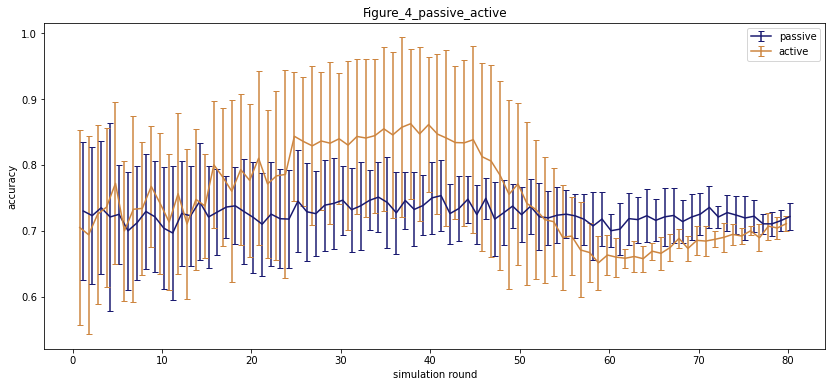

In [47]:
#plot figure
xaxis = np.arange(len(passiveMean))
plt.rcParams["figure.figsize"] = (14,6)
plt.errorbar(xaxis+1.2, passiveMean, yerr = passiveStd,  label = 'passive', color = 'midnightblue', ecolor='midnightblue',capsize=3)
plt.errorbar(xaxis+0.8, activeMean, yerr = activeStd, label = 'active', color = 'peru', ecolor='peru',capsize=3)

plt.xlabel("simulation round")
plt.ylabel("accuracy")
plt.title("Figure_4_passive_active")
plt.legend()
plt.show()

In [68]:
# change QBC to mellow
def mellowQBC(models, xtest, ytest):
    adj = 1.0e-20 # handle log(0)
    entropy=[]
    for i, x in enumerate(xtest):
        # select x disagreed by committee
        pred =[models[j].predict(x.reshape(1,-1)) for j in range(10)]
        if len(np.unique(pred)) > 1:
            return xtest[i], ytest[i], np.delete(xtest, i, 0), np.delete(ytest, i)
    p = random.randint(0, len(xtest)-1)
    return xtest[p], ytest[p], np.delete(xtest, p, 0), np.delete(ytest, p)

In [51]:
def trainMellow(x, y):
    xObs, xUnob, yObs, yUnob = drawSample(x, y, 20) 
    trainAcc, testAcc = [], []
    while len(xUnob) > 0:
        model, train = crossValidation(xObs, yObs) 
        trainAcc.append(train)
        testAcc.append(metrics.accuracy_score(yUnob, model.predict(xUnob)))
        # update sample
        committee = bagging(xObs, yObs, 10)
        xNew, yNew, xUnob, yUnob = mellowQBC(committee, xUnob, yUnob)
        xObs = np.concatenate((xObs, [xNew]))
        yObs = np.concatenate((yObs, [yNew]))
    return trainAcc, testAcc

In [69]:
# train with mellow
obs, unobs = [], []
for i in range(10):
    random.seed(i)
    print(i)
    train, test = trainMellow(x, y)
    obs.append(train)
    unobs.append(test)
    
# calculate mean and std for 10 simulation
obsMean = [np.mean(i) for i in np.transpose(np.array(obs))]
obsStd = [np.std(i) for i in np.transpose(np.array(obs))]
unobsMean = [np.mean(i) for i in np.transpose(np.array(unobs))]
unobsStd = [np.std(i) for i in np.transpose(np.array(unobs))]
print("first round", obsMean[0], obsStd[0])

0
1
2
3
4
5
6
7
8
9
first round 0.7300000000000001 0.10535653752852739


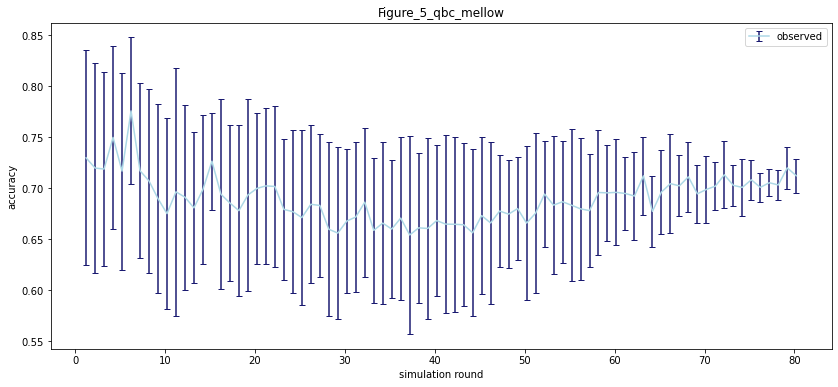

In [71]:
# plot q3 figure
xaxis = np.arange(len(obsMean))
plt.errorbar(xaxis+1.2, obsMean, yerr = obsStd,  label = 'observed', color = 'lightblue', ecolor='midnightblue',capsize=3)
# plt.errorbar(xaxis+0.8, unobsMean, yerr = unobsStd, label = 'unobserved', color = 'darkgrey', ecolor='slategrey',capsize=3)

plt.xlabel("simulation round")
plt.ylabel("accuracy")
plt.title("Figure_5_qbc_mellow")
plt.legend()
plt.show()